In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
print(os.listdir("input"))

['application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'previous_application.csv', 'sample_submission.csv']


In [5]:
# Basic Kernel or reference: https://www.kaggle.com/kailex/tidy-xgb-0-778/code
import gc
from sklearn.preprocessing import LabelEncoder 
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, train_test_split

print("Loading data...\n")
lb=LabelEncoder()
def LabelEncoding_Cat(df):
    df=df.copy()
    Cat_Var=df.select_dtypes('object').columns.tolist()
    for col in Cat_Var:
        #print(col)
        df[col]=lb.fit_transform(df[col].astype('str'))
    return df    


Loading data...



In [7]:
bureau= (pd.read_csv("input/bureau.csv")
         .pipe(LabelEncoding_Cat))

cred_card_bal=(pd.read_csv("input/credit_card_balance.csv")
               .pipe(LabelEncoding_Cat))

pos_cash_bal=(pd.read_csv("input/POS_CASH_balance.csv")
               .pipe(LabelEncoding_Cat))
               
prev =(pd.read_csv("input/previous_application.csv") 
               .pipe(LabelEncoding_Cat))

TypeError: include and exclude must both be non-string sequences

In [117]:
print("Preprocessing...\n")
Label_1=[s+'_'+l for s in bureau.columns.tolist() if s!='SK_ID_CURR' for l in ['mean','count','median','max']]
avg_bureau=bureau.groupby('SK_ID_CURR').agg(['mean','count','median','max']).reset_index()
avg_bureau.columns=['SK_ID_CURR']+Label_1

Label_2=[s+'_'+l for s in cred_card_bal.columns.tolist() if s!='SK_ID_CURR' for l in ['mean','count','median','max']]
avg_cred_card_bal=cred_card_bal.groupby('SK_ID_CURR').agg(['mean','count','median','max']).reset_index()
avg_cred_card_bal.columns=['SK_ID_CURR']+Label_2

Label_3=[s+'_'+l for s in pos_cash_bal.columns.tolist() if s not  in ['SK_ID_PREV','SK_ID_CURR'] for l in ['mean','count','median','max']]
avg_pos_cash_bal=pos_cash_bal.groupby(['SK_ID_PREV','SK_ID_CURR'])\
            .agg(['mean','count','median','max']).groupby(level='SK_ID_CURR')\
            .agg('mean').reset_index()
avg_pos_cash_bal.columns=['SK_ID_CURR']+Label_3

Label_4=[s+'_'+l for s in prev.columns.tolist() if s!='SK_ID_CURR' for l in ['mean','count','median','max']]
avg_prev=prev.groupby('SK_ID_CURR').agg(['mean','count','median','max']).reset_index()
avg_prev.columns=['SK_ID_CURR']+Label_4

del(Label_1,Label_2,Label_3,Label_4)

Preprocessing...



In [ ]:
tr = pd.read_csv("input/application_train.csv") 
te =pd.read_csv("input/application_test.csv")
tri=tr.shape[0]
y = tr.TARGET.copy()

In [ ]:
def Fill_NA(df):
    df=df.copy()
    Num_Features=df.columns
    df[Num_Features]= df[Num_Features].fillna(df[Num_Features].mode().iloc[0])
    return df

In [123]:
tr_te=(tr.drop(labels=['TARGET'],axis=1).append(te)
         .pipe(LabelEncoding_Cat)
         .pipe(Fill_NA)
         .merge(avg_bureau,on='SK_ID_CURR',how='left')
         .merge(avg_cred_card_bal,on='SK_ID_CURR',how='left')
         .merge(avg_pos_cash_bal,on='SK_ID_CURR',how='left')
         .merge(avg_prev,on='SK_ID_CURR',how='left'))

del(tr,te,bureau,cred_card_bal,pos_cash_bal,prev, avg_prev,avg_bureau,avg_cred_card_bal,avg_pos_cash_bal)
gc.collect()

1834

In [125]:
print("Preparing data...\n")
tr_te.drop(labels=['SK_ID_CURR'],axis=1,inplace=True)
tr=tr_te.iloc[:tri,:].copy()
te=tr_te.iloc[tri:,:].copy()

del(tr_te)

Preparing data...



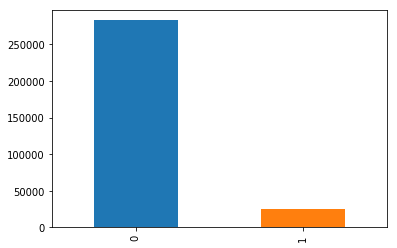

In [126]:
y.value_counts().plot('bar')

In [127]:
FEATURES = tr.columns
FEATURES

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE',
       ...
       'DAYS_LAST_DUE_median', 'DAYS_LAST_DUE_max', 'DAYS_TERMINATION_mean',
       'DAYS_TERMINATION_count', 'DAYS_TERMINATION_median',
       'DAYS_TERMINATION_max', 'NFLAG_INSURED_ON_APPROVAL_mean',
       'NFLAG_INSURED_ON_APPROVAL_count', 'NFLAG_INSURED_ON_APPROVAL_median',
       'NFLAG_INSURED_ON_APPROVAL_max'],
      dtype='object', length=440)

In [128]:
y_label = 'TARGET'
learning_rate = 0.0001
batch_size = 256
steps = 1000
buffer = 1024
label_size = 2
split = 0.20

In [129]:
tr.fillna(tr.mode().iloc[0],inplace= True)
te.fillna(tr.mode().iloc[0],inplace= True)
tr[75:80]

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,...,NAME_SELLER_INDUSTRY_mean,NAME_SELLER_INDUSTRY_count,NAME_SELLER_INDUSTRY_median,NAME_SELLER_INDUSTRY_max,CNT_PAYMENT_mean,CNT_PAYMENT_count,CNT_PAYMENT_median,CNT_PAYMENT_max,NAME_YIELD_GROUP_mean,NAME_YIELD_GROUP_count,NAME_YIELD_GROUP_median,NAME_YIELD_GROUP_max,PRODUCT_COMBINATION_mean,PRODUCT_COMBINATION_count,PRODUCT_COMBINATION_median,PRODUCT_COMBINATION_max,DAYS_FIRST_DRAWING_mean,DAYS_FIRST_DRAWING_count,DAYS_FIRST_DRAWING_median,DAYS_FIRST_DRAWING_max,DAYS_FIRST_DUE_mean,DAYS_FIRST_DUE_count,DAYS_FIRST_DUE_median,DAYS_FIRST_DUE_max,DAYS_LAST_DUE_1ST_VERSION_mean,DAYS_LAST_DUE_1ST_VERSION_count,DAYS_LAST_DUE_1ST_VERSION_median,DAYS_LAST_DUE_1ST_VERSION_max,DAYS_LAST_DUE_mean,DAYS_LAST_DUE_count,DAYS_LAST_DUE_median,DAYS_LAST_DUE_max,DAYS_TERMINATION_mean,DAYS_TERMINATION_count,DAYS_TERMINATION_median,DAYS_TERMINATION_max,NFLAG_INSURED_ON_APPROVAL_mean,NFLAG_INSURED_ON_APPROVAL_count,NFLAG_INSURED_ON_APPROVAL_median,NFLAG_INSURED_ON_APPROVAL_max
75,0,0,0,1,1,202500.0,1288350.0,37800.0,1125000.0,6,7,4,1,1,0.003069,-17542,-2011,-1529.0,-988,7.0,1,1,0,1,0,0,2,3.0,3,3,0,11,0,0,0,0,0,0,42,0.356323,...,5.8,5.0,4.0,10.0,13.600000,5.0,8.0,36.0,2.20,5.0,1.0,4.0,9.4,5.0,9.0,13.0,365243.0,5.0,365243.0,365243.0,-753.8,5.0,-672.0,-378.0,-375.8,5.0,-414.0,94.0,-519.8,5.0,-522.0,-48.0,-514.200000,5.0,-516.0,-40.0,0.400000,5.0,0.0,1.0
76,1,0,0,0,0,112500.0,135000.0,6750.0,135000.0,6,1,1,1,1,0.022800,-19467,-4066,-4623.0,-2975,7.0,1,1,0,1,0,0,8,2.0,2,2,4,15,0,0,0,0,0,0,39,0.356323,...,7.5,2.0,7.5,10.0,26.000000,2.0,26.0,42.0,3.50,2.0,3.5,4.0,9.5,2.0,9.5,11.0,365243.0,2.0,365243.0,365243.0,-947.0,2.0,-947.0,-389.0,-197.0,2.0,-197.0,841.0,182004.0,2.0,182004.0,365243.0,182007.500000,2.0,182007.5,365243.0,0.500000,2.0,0.5,1.0
77,0,1,0,1,0,135000.0,337761.0,15781.5,256500.0,6,7,4,0,1,0.025164,-9666,-2811,-4437.0,-2342,7.0,1,1,0,1,1,0,8,2.0,2,2,5,12,0,0,0,0,0,0,42,0.356323,...,8.5,4.0,10.0,10.0,25.333333,3.0,18.0,48.0,1.75,4.0,1.5,4.0,5.0,4.0,4.5,9.0,365243.0,1.0,365243.0,365243.0,-1761.0,1.0,-1761.0,-1761.0,-1491.0,1.0,-1491.0,-1491.0,-1491.0,1.0,-1491.0,-1491.0,-1486.000000,1.0,-1486.0,-1486.0,0.000000,1.0,0.0,0.0
78,0,0,0,1,1,94500.0,585000.0,28273.5,585000.0,6,7,4,1,1,0.028663,-18253,-721,-1701.0,-1779,7.0,1,1,0,1,1,0,3,3.0,2,2,5,16,0,0,0,0,0,0,35,0.592701,...,5.6,10.0,4.0,10.0,18.000000,7.0,12.0,60.0,1.90,10.0,1.5,4.0,8.5,10.0,9.0,13.0,365243.0,6.0,365243.0,365243.0,-1441.0,6.0,-1569.5,-466.0,-1141.0,6.0,-1239.5,-316.0,-1181.0,6.0,-1329.5,-316.0,-1175.666667,6.0,-1325.0,-310.0,0.166667,6.0,0.0,1.0
79,0,0,0,1,0,108000.0,113760.0,5301.0,90000.0,6,3,1,3,1,0.030755,-22935,365243,-12623.0,-3442,7.0,1,0,0,1,0,0,8,1.0,2,2,4,10,0,0,0,0,0,0,57,0.356323,...,6.0,1.0,6.0,6.0,16.000000,1.0,16.0,16.0,2.00,1.0,2.0,2.0,11.0,1.0,11.0,11.0,365243.0,1.0,365243.0,365243.0,-173.0,1.0,-173.0,-173.0,277.0,1.0,277.0,277.0,365243.0,1.0,365243.0,365243.0,365243.000000,1.0,365243.0,365243.0,0.000000,1.0,0.0,0.0


In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
tr = pca.fit_transform(tr)
te = pca.transform(te)

In [130]:
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.feature_selection import chi2, f_classif
rc = MinMaxScaler()
print(type(tr))
s = SelectPercentile(chi2,percentile=60)

<class 'pandas.core.frame.DataFrame'>


In [131]:
#kf = KFold(n_splits=2,shuffle=True,random_state=35)
#for _ in range(2):shape
trainX, validationX, trainY, validationY = train_test_split(tr,y,test_size=0.20,random_state=64)
print(trainX.shape)
print(validationX.shape)
scale_tr = rc.fit_transform(trainX)
scale_vl = rc.transform(validationX)
#scale_tr = pd.DataFrame(scale_tr,columns=FEATURES, index= trainX.index)
X_new  = s.fit_transform(scale_tr, trainY)
y_new = s.transform(scale_vl)
NFEATURES = FEATURES[s.get_support()]
X_new = pd.DataFrame(X_new,columns=NFEATURES,index= trainX.index)
y_new = pd.DataFrame(y_new,columns=NFEATURES,index= validationX.index)
print(len(NFEATURES),X_new.shape,trainY.shape,y_new.shape,validationY.shape)
trainY.value_counts()

(246008, 440)
(61503, 440)
264 (246008, 264) (246008,) (61503, 264) (61503,)


0    226132
1     19876
Name: TARGET, dtype: int64

In [132]:
i = trainY[trainY == 0].index
dr = np.random.choice(i,len(i)-23000,replace=False)
len(dr)

203132

In [133]:
X_new.drop(dr,inplace=True)
trainY.drop(dr,inplace=True)
trainY.value_counts()

0    23000
1    19876
Name: TARGET, dtype: int64

In [134]:
all(k!=False for k in tr.index == y.index)

True

In [173]:
feature_columns = [tf.feature_column.numeric_column(f) for f in NFEATURES]
model = tf.estimator.DNNClassifier(hidden_units=[1024,512,256],
                                   feature_columns=feature_columns,
                                   optimizer = tf.train.AdagradOptimizer(learning_rate=0.01),
                                   activation_fn=tf.nn.elu,
                                   dropout=0.5) 

In [178]:
train_input = tf.estimator.inputs.pandas_input_fn(x=X_new,y=trainY,batch_size=256,shuffle=True)
#for i in range(5):128
model.train(input_fn=train_input,steps=40000)

In [179]:
#scale_validationX = rc.transform(validationX)
#scale_validationX = pd.DataFrame(scale_tr,columns=FEATURES, index= validationX.index)
validation_input= tf.estimator.inputs.pandas_input_fn(x=y_new,y=validationY,batch_size=batch_size,shuffle=False)
eval_res = model.evaluate(input_fn=validation_input)
print('Accuracy: ',eval_res['accuracy'])
validationY.value_counts()    
#scale_te = rc.transform(te[NFEATURES])    

Accuracy:  0.695625


0    56554
1     4949
Name: TARGET, dtype: int64

In [176]:
preds = list(model.predict(input_fn=validation_input))  #validation
pred_list = list(map(lambda x: x['class_ids'][0],preds))
pred_list.count(1)

19240

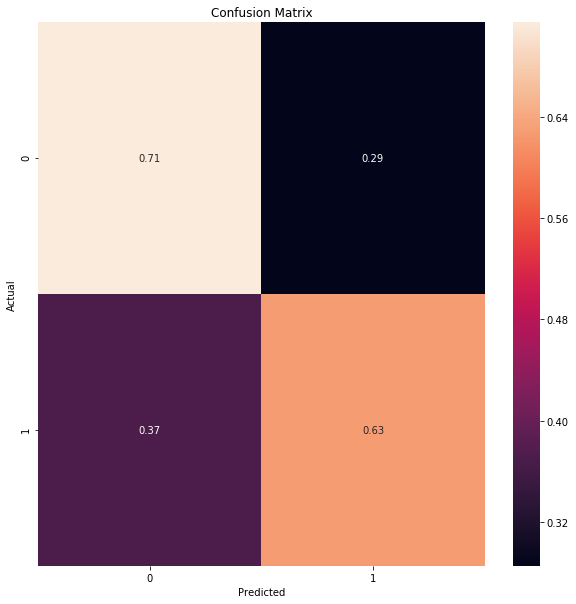

In [180]:
plt.figure(figsize=(10,10))
plt.title('Confusion Matrix')
cm = tf.confusion_matrix(validationY.values,pred_list)
with tf.Session() as session:
    cm_out = session.run(cm)

cm_out = cm_out.astype(float) / cm_out.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_out, annot=True, xticklabels=range(2), yticklabels=range(2));
plt.ylabel('Actual');
plt.xlabel('Predicted');
session.close()

In [ ]:
scale_tst = rc.transform(te)
te_new = s.transform(scale_tst)
te_new = pd.DataFrame(te_new,columns=NFEATURES,index= te.index)

In [ ]:
test_input = tf.estimator.inputs.pandas_input_fn(x=te_new,batch_size=batch_size,shuffle=False)
preds_test = list(model.predict(input_fn=test_input))  #prediction on test

In [ ]:
pred_list = list(map(lambda x: x['class_ids'][0],preds_test))

In [ ]:
te.info()

In [ ]:
sub = pd.read_csv('../input/sample_submission.csv')
sub.head()

In [ ]:
sub['TARGET'] = pd.Series(pred_list).astype(np.float64)
sub.to_csv('submit_k_9.csv',index=False)
sub.head()

In [ ]:
sub['TARGET'].value_counts()